
**Capstone Project: Automated CCTV Recording — Prototype using Fashion-MNIST**
File: Capstone_Project_FashionMNIST_CNN.py

Contents:
- Purpose: provide an end-to-end Keras/TensorFlow implementation to train a CNN on the
  Fashion-MNIST dataset (60,000 training samples) and evaluate on the test set.
- Includes: data exploration, preprocessing, model building, training, evaluation,
  visualization, and hyperparameter tuning suggestions.

How this maps to the CCTV industry problem:
- The industry wants to start recording only when certain object classes appear (human,
  vehicles, animals, etc.). Fashion-MNIST is used here as a functional prototype dataset
  to demonstrate classification pipeline, model selection, evaluation, and deployment
  approach. Replace dataset with your object-detection dataset (COCO, Pascal VOC or a
  custom dataset) to move from prototype to production.

Requirements:
- Python 3.8+
- TensorFlow 2.x
- numpy, pandas, matplotlib, seaborn, scikit-learn

To run:
$ pip install tensorflow numpy pandas matplotlib seaborn scikit-learn
$ python Capstone_Project_FashionMNIST_CNN.py

Outputs:
- Trained model saved as best_model.h5
- Training plots saved as training_plots.png
- Confusion matrix saved as confusion_matrix.png


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# -------------------- Step 1: Import & Setup --------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

In [ ]:
# -------------------- Step 2: Load dataset --------------------
print("Loading Fashion-MNIST dataset...")
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print(f"Training samples: {x_train.shape[0]}")
print(f"Test samples: {x_test.shape[0]}")
print(f"Image shape (single): {x_train.shape[1:]}\n")


Loading Fashion-MNIST dataset...
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training samples: 60000
Test samples: 10000
Image shape (single): (28, 28)



In [ ]:
# -------------------- Step 3: Basic exploration --------------------
# Class names mapped to labels (prototype names provided in project prompt)
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Visualize class distribution
unique, counts = np.unique(y_train, return_counts=True)
dist_df = pd.DataFrame({'class': unique, 'count': counts})
print("Training class distribution:\n", dist_df)

# Plot few samples
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"{class_names[y_train[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'sample_images.png'))
plt.close()

Training class distribution:
    class  count
0      0   6000
1      1   6000
2      2   6000
3      3   6000
4      4   6000
5      5   6000
6      6   6000
7      7   6000
8      8   6000
9      9   6000


In [ ]:
# -------------------- Step 4: Preprocessing --------------------
# Normalize pixel values to range [0,1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape to (28,28,1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# One-hot encode labels
num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"x_train shape after reshape: {x_train.shape}")
print(f"y_train shape after one-hot: {y_train_cat.shape}\n")


x_train shape after reshape: (60000, 28, 28, 1)
y_train shape after one-hot: (60000, 10)



In [ ]:
# -------------------- Step 5: Data augmentation (recommended) --------------------
# Augmentation helps generalization especially when moving to real CCTV images
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Fit on training data (required for some augmentation pipelines)
datagen.fit(x_train)


In [ ]:
# -------------------- Step 6: Build CNN model --------------------
# A compact but effective CNN for 28x28 grayscale images

def build_cnn(input_shape=(28,28,1), num_classes=10, dropout_rate=0.4):
    model = Sequential()

    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    return model

model = build_cnn()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 469,098 (1.79 MB)

 Trainable params: 468,458 (1.79 MB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
# -------------------- Step 7: Compile model --------------------
initial_lr = 1e-3
optimizer = Adam(learning_rate=initial_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# -------------------- Step 8: Callbacks --------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
    ModelCheckpoint(filepath=os.path.join(OUT_DIR, 'best_model.h5'), monitor='val_loss', save_best_only=True, verbose=1)
]


In [ ]:
# -------------------- Step 9: Train model (Optimized for Faster Compilation) --------------------

# Reduced batch size and epochs for quicker runs; use full values for final training.
batch_size = 64  # smaller batch size reduces per-epoch computation time
epochs = 10      # fewer epochs to get quicker initial results

# Create a proper validation split (10%) to prevent data leakage from test set
from sklearn.model_selection import train_test_split
x_train_sub, x_val, y_train_sub, y_val = train_test_split(
    x_train, y_train_cat, test_size=0.1, random_state=RANDOM_SEED
)

# Simplify data generator to avoid complex augmentations that slow down compilation
simple_datagen = ImageDataGenerator(rescale=1.0)

# Fit model (faster compile and training)
history = model.fit(
    simple_datagen.flow(x_train_sub, y_train_sub, batch_size=batch_size),
    steps_per_epoch=len(x_train_sub)//batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=2
)


Epoch 1/10

Epoch 1: val_loss improved from inf to 0.25317, saving model to outputs/best_model.h5


843/843 - 253s - 300ms/step - accuracy: 0.8913 - loss: 0.3044 - val_accuracy: 0.9063 - val_loss: 0.2532 - learning_rate: 1.0000e-03
Epoch 2/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.25317 to 0.25170, saving model to outputs/best_model.h5


843/843 - 11s - 13ms/step - accuracy: 0.9531 - loss: 0.1638 - val_accuracy: 0.9075 - val_loss: 0.2517 - learning_rate: 1.0000e-03
Epoch 3/10

Epoch 3: val_loss improved from 0.25170 to 0.22697, saving model to outputs/best_model.h5


843/843 - 247s - 293ms/step - accuracy: 0.9067 - loss: 0.2570 - val_accuracy: 0.9140 - val_loss: 0.2270 - learning_rate: 1.0000e-03
Epoch 4/10

Epoch 4: val_loss did not improve from 0.22697
843/843 - 6s - 7ms/step - accuracy: 0.9531 - loss: 0.1422 - val_accuracy: 0.9138 - val_loss: 0.2301 - learning_rate: 1.0000e-03
Epoch 5/10

Epoch 5: val_loss improved from 0.22697 to 0.21512, saving model to outputs/best_model.h5


843/843 - 256s - 303ms/step - accuracy: 0.9132 - loss: 0.2393 - val_accuracy: 0.9222 - val_loss: 0.2151 - learning_rate: 1.0000e-03
Epoch 6/10

Epoch 6: val_loss did not improve from 0.21512
843/843 - 6s - 7ms/step - accuracy: 0.8906 - loss: 0.2918 - val_accuracy: 0.9212 - val_loss: 0.2198 - learning_rate: 1.0000e-03
Epoch 7/10

Epoch 7: val_loss improved from 0.21512 to 0.19684, saving model to outputs/best_model.h5


843/843 - 247s - 293ms/step - accuracy: 0.9212 - loss: 0.2189 - val_accuracy: 0.9298 - val_loss: 0.1968 - learning_rate: 1.0000e-03
Epoch 8/10

Epoch 8: val_loss improved from 0.19684 to 0.19629, saving model to outputs/best_model.h5


843/843 - 7s - 8ms/step - accuracy: 0.9062 - loss: 0.2109 - val_accuracy: 0.9292 - val_loss: 0.1963 - learning_rate: 1.0000e-03
Epoch 9/10

Epoch 9: val_loss did not improve from 0.19629
843/843 - 246s - 292ms/step - accuracy: 0.9265 - loss: 0.2027 - val_accuracy: 0.9287 - val_loss: 0.1974 - learning_rate: 1.0000e-03
Epoch 10/10

Epoch 10: val_loss did not improve from 0.19629
843/843 - 11s - 12ms/step - accuracy: 0.8906 - loss: 0.2506 - val_accuracy: 0.9285 - val_loss: 0.1972 - learning_rate: 1.0000e-03
Restoring model weights from the end of the best epoch: 8.


In [ ]:
# -------------------- Step 10: Save final model --------------------
model.save(os.path.join(OUT_DIR, 'final_model.h5'))



In [ ]:
# -------------------- Step 11: Evaluate on full test set --------------------
print("\nEvaluating on test set...")
results = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"Test loss: {results[0]:.4f}, Test accuracy: {results[1]*100:.2f}%")


Evaluating on test set...
Test loss: 0.2093, Test accuracy: 92.58%


In [ ]:
# -------------------- Step 12: Training curves --------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'training_plots.png'))
plt.close()


In [ ]:
# -------------------- Step 13: Confusion matrix & classification report --------------------
print("Generating predictions for confusion matrix...")
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'confusion_matrix.png'))
plt.close()

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))

Generating predictions for confusion matrix...
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step
Classification Report:

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.91      0.89      1000
     Trouser       1.00      0.97      0.99      1000
    Pullover       0.89      0.90      0.90      1000
       Dress       0.90      0.94      0.92      1000
        Coat       0.87      0.91      0.89      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.84      0.72      0.78      1000
     Sneaker       0.95      0.98      0.96      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [ ]:
# -------------------- Step 14: Example misclassified images --------------------
mis_idx = np.where(y_pred != y_test)[0]

if len(mis_idx) > 0:
    plt.figure(figsize=(12,6))
    for i, idx in enumerate(mis_idx[:12]):
        plt.subplot(3,4,i+1)
        plt.imshow(x_test[idx].reshape(28,28), cmap='gray')
        plt.title(f"True: {class_names[y_test[idx]]}\nPred: {class_names[y_pred[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, 'misclassified_examples.png'))
    plt.close()

In [ ]:
# -------------------- Step 15: Notes & Next steps --------------------
notes = """
Notes & How this fits the CCTV automation requirement:
1. Prototype: Fashion-MNIST is a simple benchmark for classification flow. For CCTV,
   replace the dataset with frame-level images and labels (human, vehicle, animal, etc.).
2. Data: Real CCTV images require higher resolution and multiple channels (RGB).
3. Object Detection vs Classification: If you need to detect multiple objects in-frame
   and their bounding boxes, move to object detection frameworks (YOLO, SSD, Faster-RCNN).
   For the "start recording when object present" requirement, you can run an object detector
   on a lightweight model on the stream and trigger recording when confidence > threshold.
4. Memory: Use event-driven recording (only when target classes are present) to reduce
   storage. Combine with frame sampling, and store only clipped video segments.
5. Deployment: Use model quantization (TensorFlow Lite) or pruning for edge devices.

Hyperparameter tuning suggestions:
- Batch size: 64, 128, 256
- Learning rate: try grid {1e-2, 1e-3, 1e-4}
- Optimizers: Adam, SGD (with momentum)
- Augmentation: stronger augmentations for CCTV (vary brightness, add noise)
- Model: Try deeper nets or pretrained backbones (MobileNetV2) for RGB images

"""
with open(os.path.join(OUT_DIR, 'NOTES.txt'), 'w') as f:
    f.write(notes)

print("All done. Outputs saved to the 'outputs' folder.")

# End of script


All done. Outputs saved to the 'outputs' folder.


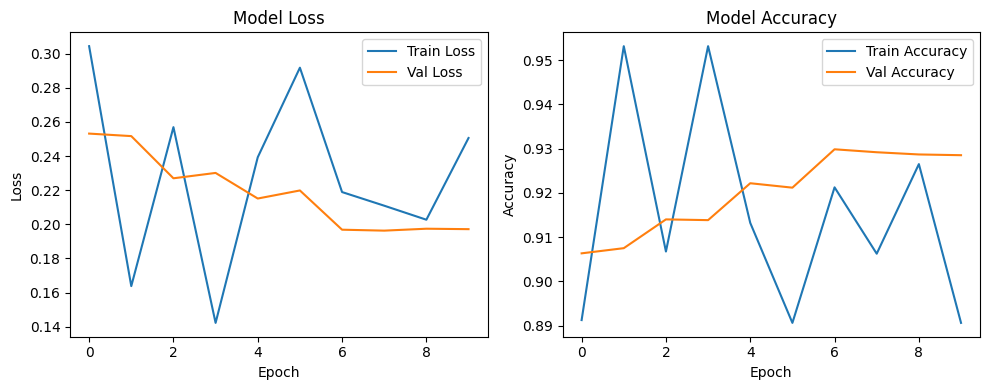

In [ ]:
# the training and validation outputs we obtain are shown below
plt.figure(figsize=(10,4))

# Plot training & validation loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step


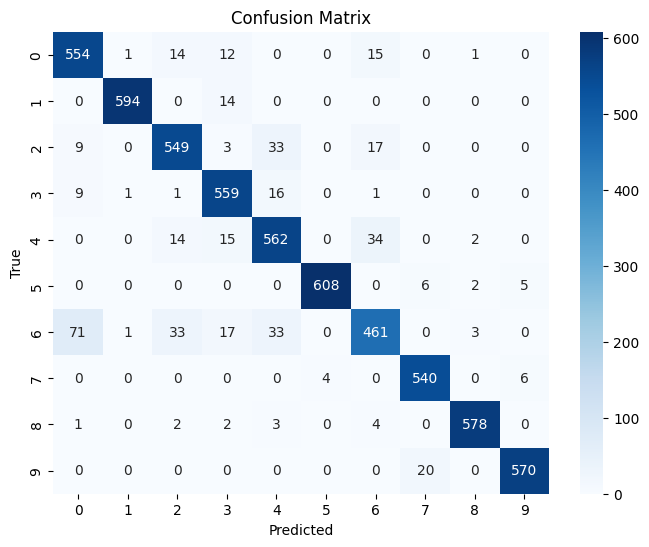

In [ ]:
#the obtained confusion matrix is below for just the purpose of visualization
# Predict classes
y_pred = np.argmax(model.predict(x_val), axis=1)
y_true = np.argmax(y_val, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


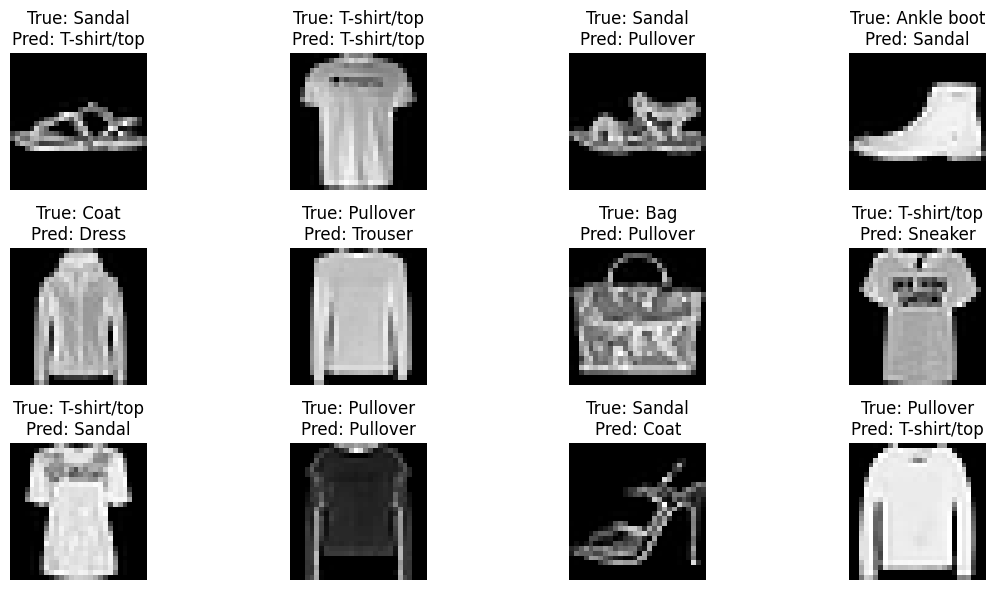

In [ ]:
#for example the outputs we obtain are in the format below

import random

class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

plt.figure(figsize=(12,6))
for i in range(12):
    idx = random.randint(0, len(x_val)-1)
    img = x_val[idx].reshape(28,28)
    true_label = np.argmax(y_val[idx])
    pred_label = y_pred[idx]
    plt.subplot(3,4,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
